In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
meas = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

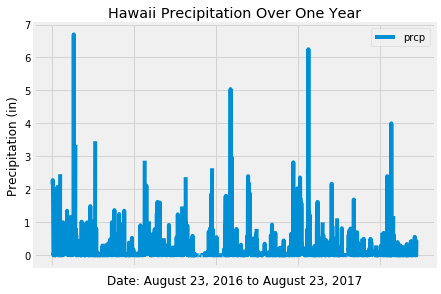

In [26]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
from dateutil.parser import parse
recent = session.query(func.max(meas.date)).scalar()
most_recent= parse(recent)
year= (dt.timedelta(days=365))
last_year= (most_recent)-year

# Perform a query to retrieve the date and precipitation scores
rain_data=session.query(meas.date,meas.prcp).filter(meas.date>last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_data_df=pd.DataFrame(rain_data, columns= ['date', 'prcp'])


# Sort the dataframe by date
rain_data_df =rain_data_df.sort_values(by='date',ascending=True)
rain_data_df=rain_data_df.set_index('date')

## Use Pandas Plotting with Matplotlib to plot the data
rain_data_df.plot()
plt.tight_layout()

plt.title("Hawaii Precipitation Over One Year")
plt.ylabel("Precipitation (in)")
plt.xlabel("Date: August 23, 2016 to August 23, 2017")
plt.grid(b=True, which='major', color='lightgray', linestyle='-')

plt.show()

![precipitation](Images/precipitation.png)

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [29]:
# Getting column names and types for stations table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [30]:
#Getting column names for measurements table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [31]:
# Design a query to show how many stations are available in this dataset?
location_station = session.query(meas).group_by(meas.station).count()
print(f"There are {location_station} weather stations available in Hawaii.")

There are 9 weather stations available in Hawaii.


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity =(session.query(meas.station, func.count(meas.station)).
                   group_by(meas.station).order_by(func.count(meas.station).desc()).all()
                                                       )
#make the df     
station_activity_df = pd.DataFrame(station_activity, columns=['Station','Number of Observations'])
best_station=station_activity_df.iloc[0][0]
best_station_count=station_activity_df.iloc[0][1]
station_activity_df.set_index('Station', inplace=True)
print(f'The most active station is station: {best_station}, with {best_station_count} observations.')
print(station_activity_df)

The most active station is station: USC00519281, with 2772 observations.
             Number of Observations
Station                            
USC00519281                    2772
USC00519397                    2724
USC00513117                    2709
USC00519523                    2669
USC00516128                    2612
USC00514830                    2202
USC00511918                    1979
USC00517948                    1372
USC00518838                     511


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)).filter(meas.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

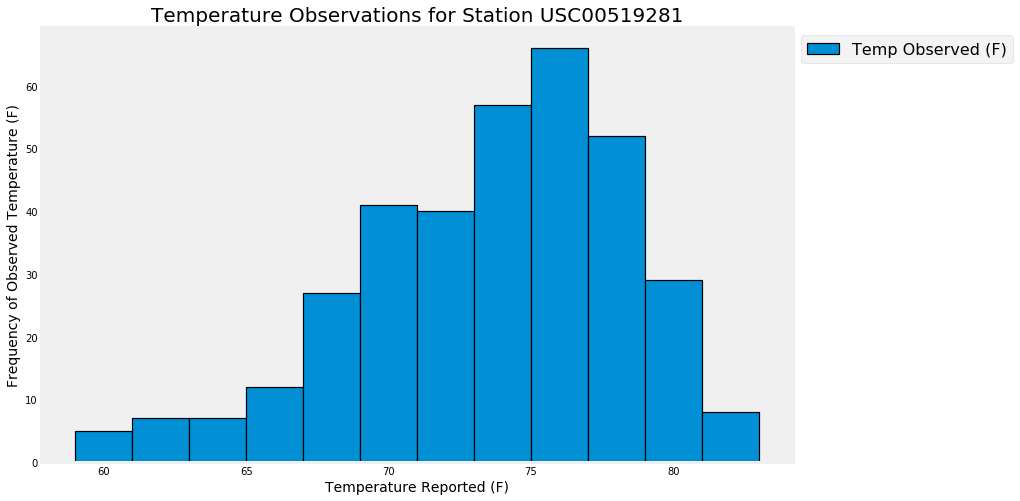

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_all=(session.query(meas.station, meas.date, meas.tobs).filter(meas.station==best_station).
           filter(meas.date>last_year).order_by(meas.date).all())
temps_df=pd.DataFrame(temps_all, columns=['station name', 'date', 'Temp Observed (F)'])
temps_df.set_index('station name', inplace=True)

temps_df.plot.hist(by='station', bins=12, figsize=(12,8), edgecolor='black', linewidth=1.2)
plt.grid()
plt.title("Temperature Observations for Station " + best_station, fontsize=20)
plt.xlabel("Temperature Reported (F)", fontsize=14)
plt.ylabel("Frequency of Observed Temperature (F)", fontsize= 14)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("../StationTemps.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (session.query(func.min(meas.tobs), func.avg(meas.tobs), func.max(meas.tobs)).
            filter(meas.date >= start_date).filter(meas.date <= end_date).all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
